In [157]:
import warnings

import matplotlib.pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from IPython.display import clear_output
from PIL import Image
from matplotlib import cm
from time import perf_counter
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.optim import Optimizer
from torchsummary import summary
from skimage import io, transform
import os
from torchvision.transforms import Compose, PILToTensor, Normalize
import torchvision.transforms as T
from torch.utils.data import random_split
import torch.nn.functional as F

#from torchvision.datasets import MNIST
#from torchvision.datasets import CIFAR10
# from torchvision.transforms.v2 import Compose, PILToTensor, ToDtype, Normalize

warnings.filterwarnings('ignore')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
plt.rc('font', size=30)
device

device(type='cpu')

In [2]:
print(np.__version__)
print(torch.__version__)

1.21.6
1.13.1


In [17]:
masks_path = 'train_lung_masks/'
images_path = 'train_images/'
path = '/Users/igor/Documents/ML/ml_yandex-project/data/'

In [75]:
#plt.imshow(io.imread(path + masks_path + 'img_3058.png'), cmap='gray')
io.imread(path + masks_path + 'img_3058.png').shape

(256, 256)

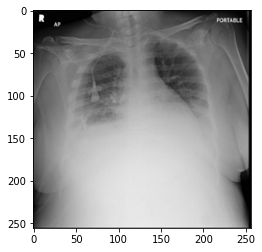

In [5]:
plt.imshow(io.imread(images_path + 'img_3058.png'), cmap='gray')

In [66]:
def show_image(path, number, image_path='train_lung_masks/', mask_path='train_images/'):
    f, (lungs, mask) = plt.subplots(1, 2, sharex=True, sharey=True)
    lungs.axis('off')
    lungs.imshow(io.imread(path + image_path + f'img_{number}.png'), cmap='gray')
    mask.axis('off')
    mask.imshow(io.imread(path + mask_path + f'img_{number}.png'), cmap='gray')


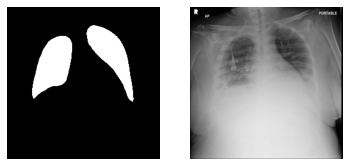

In [67]:
show_image(path, 3058)

In [136]:
class LungsDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None, image_subdir='train_images/', masks_subdir='train_lung_masks/'):
        self.images_dir = os.path.join(root_dir, image_subdir)
        self.masks_dir = os.path.join(root_dir, masks_subdir)
        self.images_list = os.listdir(self.images_dir)
        self.transform = transform
    def __len__(self):
        return len(self.images_list)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        image = Image.open(os.path.join(self.images_dir, f'img_{idx}.png'))
        mask = Image.open(os.path.join(self.masks_dir, f'img_{idx}.png'))
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        return image, mask

In [137]:
def imshow(tensor):
    image = T.ToPILImage()(tensor)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

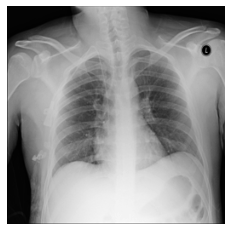

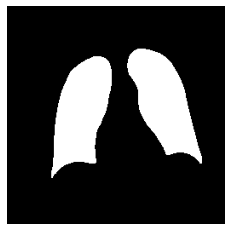

In [143]:
transform = T.Compose([
    T.ToTensor()
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = LungsDataset(path, transform=transform)

imshow(dataset[3][0])
imshow(dataset[3][1])

In [144]:
test_size = int(len(dataset) * 0.2) 

train_size = len(dataset) - test_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True,  pin_memory=True)
train_loader = DataLoader(test_dataset, batch_size=128, shuffle=True,  pin_memory=True)

In [145]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3)
        self.act1  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3)
        self.act2  = nn.ReLU()
    
    def forward(self, x):
        return self.act2(self.conv2(self.act1(self.conv1(x))))

In [159]:
class Encoder(nn.Module):
    def __init__(self, chs=(1,64,128,256,512,1024)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs


class Decoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 64)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = T.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs


class UNet(nn.Module):
    def __init__(self, enc_chs=(1,64,128,256,512,1024), dec_chs=(1024, 512, 256, 128, 64), num_class=1, retain_dim=False, out_sz=(572,572)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim
        self.out_sz  = out_sz

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, self.out_sz)
        return out

In [153]:
dataset[0][0].shape

torch.Size([1, 256, 256])

In [160]:
model1 = UNet(enc_chs=(1,64,128,256,512), dec_chs=(512, 256, 128, 64), retain_dim=True, out_sz=(256,256)).to(device)

summary(model1, (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 254, 254]             640
              ReLU-2         [-1, 64, 254, 254]               0
            Conv2d-3         [-1, 64, 252, 252]          36,928
              ReLU-4         [-1, 64, 252, 252]               0
             Block-5         [-1, 64, 252, 252]               0
         MaxPool2d-6         [-1, 64, 126, 126]               0
            Conv2d-7        [-1, 128, 124, 124]          73,856
              ReLU-8        [-1, 128, 124, 124]               0
            Conv2d-9        [-1, 128, 122, 122]         147,584
             ReLU-10        [-1, 128, 122, 122]               0
            Block-11        [-1, 128, 122, 122]               0
        MaxPool2d-12          [-1, 128, 61, 61]               0
           Conv2d-13          [-1, 256, 59, 59]         295,168
             ReLU-14          [-1, 256,